Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


Lendo a base de dados

In [2]:
df = pd.read_csv ('Air_Traffic_Passenger_Statistics.csv') 
df.head(3)

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,"27,271"
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,"29,131"
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,"5,415"


Histogramas

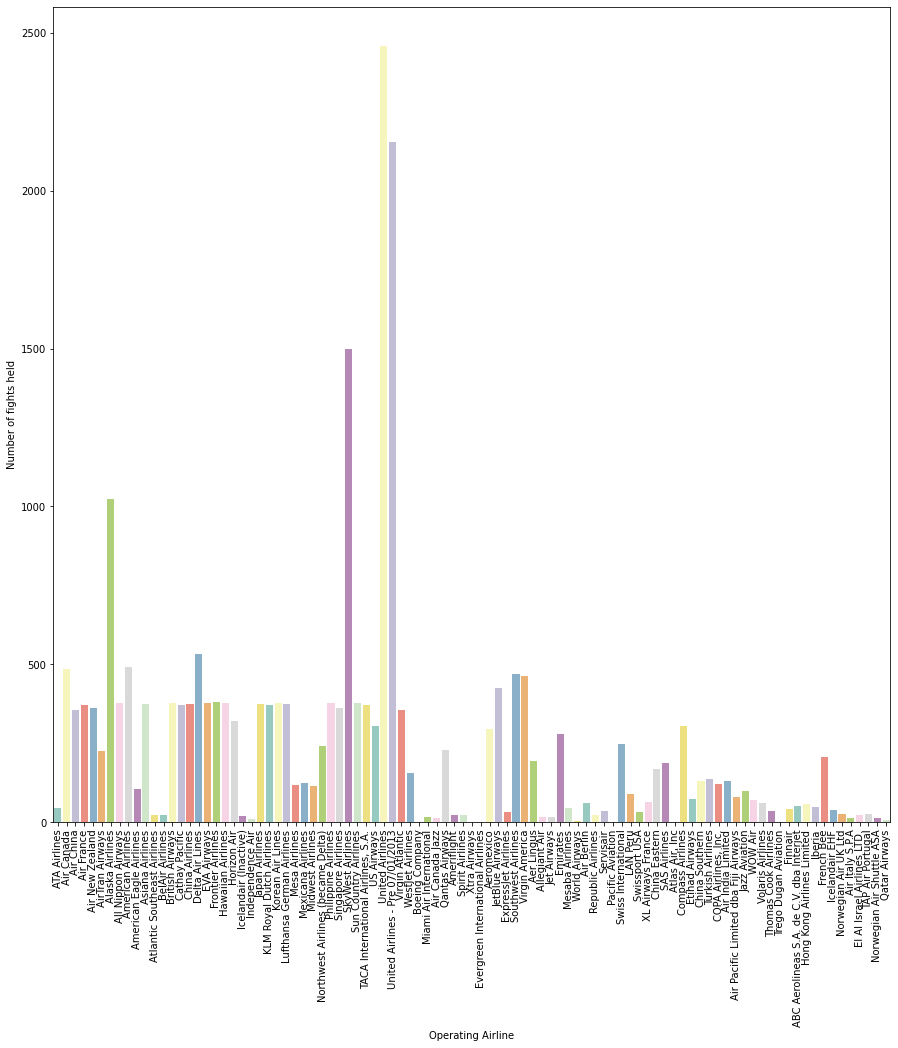

In [3]:
# Histograma da quantidade de voos por companhia aérea
plt.figure(figsize = (15,15))
sns.countplot(x = "Operating Airline", palette = "Set3",data = df)
plt.xticks(rotation = 90)
plt.ylabel("Number of fights held")
plt.show()

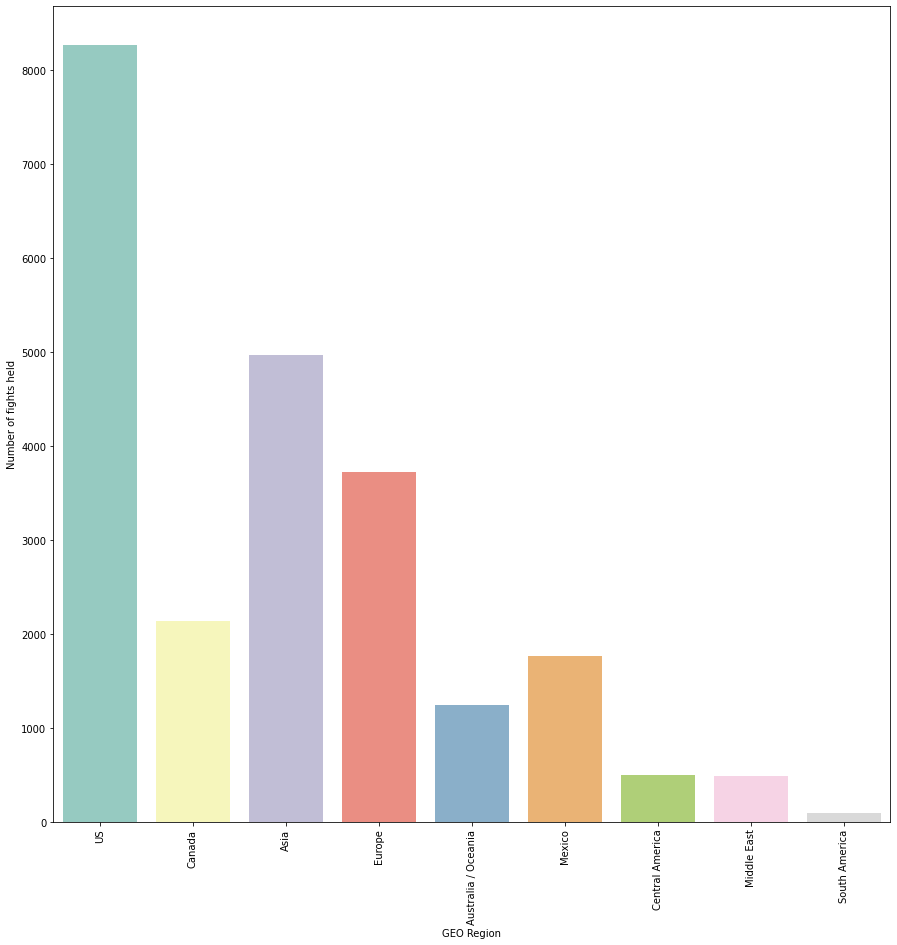

In [4]:
# Histograma da quantidade de voos por região
plt.figure(figsize = (15,15))
sns.countplot(x = "GEO Region", palette = "Set3",data = df)
plt.xticks(rotation = 90)
plt.ylabel("Number of fights held")
plt.show()

Analisando o tipo dos dados

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23178 entries, 0 to 23177
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              23178 non-null  int64 
 1   Operating Airline            23178 non-null  object
 2   Operating Airline IATA Code  23104 non-null  object
 3   Published Airline            23178 non-null  object
 4   Published Airline IATA Code  23104 non-null  object
 5   GEO Summary                  23178 non-null  object
 6   GEO Region                   23178 non-null  object
 7   Activity Type Code           23178 non-null  object
 8   Price Category Code          23178 non-null  object
 9   Terminal                     23178 non-null  object
 10  Boarding Area                23178 non-null  object
 11  Passenger Count              23178 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.1+ MB


Transforma em atributo numérico

In [6]:
# Precisamos trabalhar com a variável "Passenger Count" como sendo numérica, 
# portanto foi necessário realizar essa transformação

# Remove a vírgula
df['Passenger Count'] = df['Passenger Count'].str.replace(',', '')

# Transforma a coluna em float
df['Passenger Count'] = df['Passenger Count'].astype(int)

In [7]:
# dataframe após a transformação
df.head(3)

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415


Aplicar agrupamento

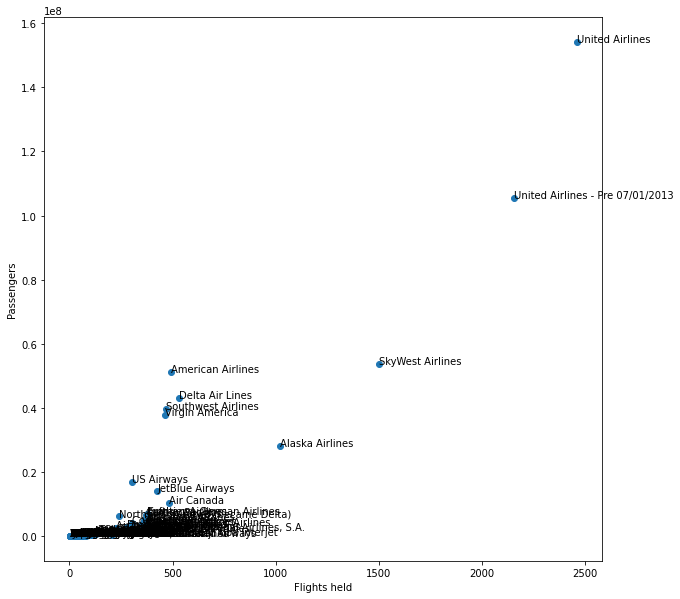

In [8]:
# Esse agrupamento foi realizado para observar a distribuiçao dos dados (se possui algum outlier)
# e organizar os dados que utilizaremos na clusterização dos algoritmos K-Means e DBScan

#quantidade de vezes em que aparece a companhia aérea no dataframe
airline_count = df["Operating Airline"].value_counts()
#ordena por ordem alfabética 
airline_count.sort_index(inplace=True)

#faz agrupamento da quantidade de passageiros por companhia aérea
passenger_count = df.groupby("Operating Airline").sum()["Passenger Count"]
# ordena por ordem alfabética os agrupamentos
passenger_count.sort_index(inplace=True)

# Gráfico de dispersão
x = airline_count.values #companhia aérea
y = passenger_count.values #quantidade de passageiros
plt.figure(figsize = (10,10))
plt.scatter(x, y)
plt.xlabel("Flights held")
plt.ylabel("Passengers")
for i, txt in enumerate(airline_count.index.values):
    a = plt.gca()
    plt.annotate(txt, (x[i], y[i]))
plt.show()

Remover outlier

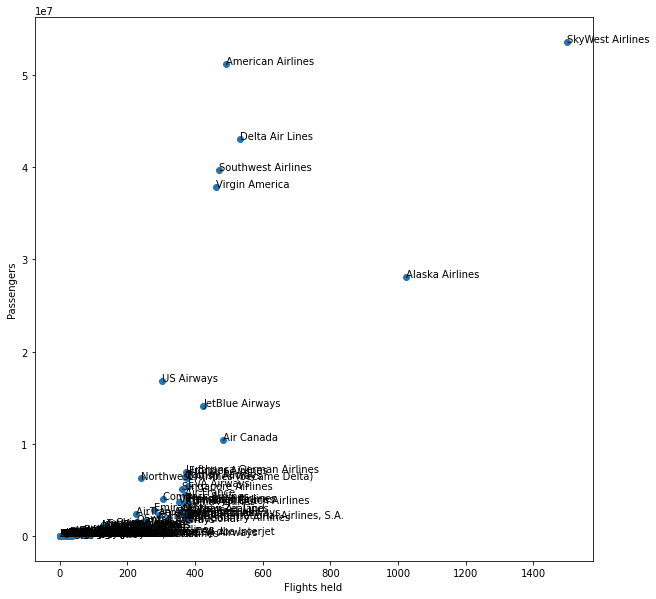

In [9]:
# Foi definido remover os dois dados que estão mais isolados dos demais (considerados como outliers) 
df_1 = airline_count + passenger_count 
df_1.sort_values(ascending = False, inplace = True)
outliers = df_1.head(2).index.values
airline_count = airline_count.drop(outliers)
airline_count.sort_index(inplace=True)
passenger_count = passenger_count.drop(outliers)
passenger_count.sort_index(inplace = True)
x = airline_count.values 
y = passenger_count.values 

# Gráfico de dispersão atualizado
plt.figure(figsize = (10,10))
plt.scatter(x, y)
plt.xlabel("Flights held")
plt.ylabel("Passengers")
for i, txt in enumerate(airline_count.index.values):
    a = plt.gca()
    plt.annotate(txt, (x[i], y[i]))
plt.show()

Gráfico do Cotovelo

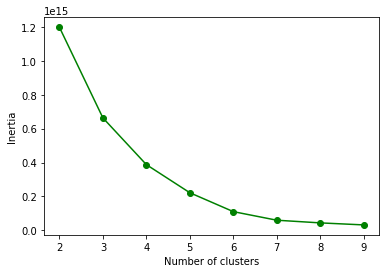

In [10]:
# O gráfico do cotovelo foi utilizado para encontrar a melhor quantidade de K a ser utilizada pelo algoritmo K-Means

X = np.array(list(zip(x,y)))
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,10), inertias, "o-g")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [11]:
# Melhor quantidade de K = 6

#K-Means

K = 4

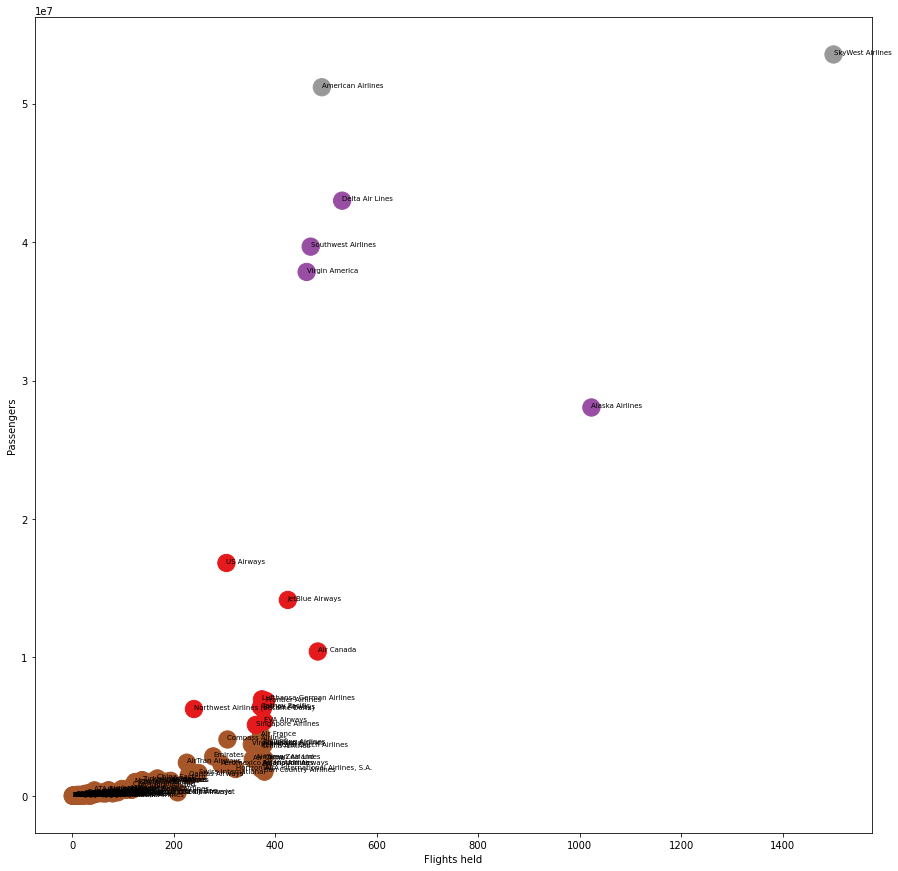

In [12]:
# Aplicação do algoritmo K-Means
kmeans = KMeans(n_clusters=4) # definindo a quantidade de clusters como 4
kmeans.fit(X) # realiza o treinamento
y_kmeans = kmeans.predict(X) # faz a predição

# Gráfico exibindo a clusterização realizada pelo K-Means
plt.figure(figsize = (15,15))
plt.xlabel("Flights held")
plt.ylabel("Passengers")
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=300, cmap='Set1')
for i, txt in enumerate(airline_count.index.values):
    plt.annotate(txt, (X[i,0], X[i,1]), size = 7)
plt.show()

The average silhouette_score is :0.7512738457544981


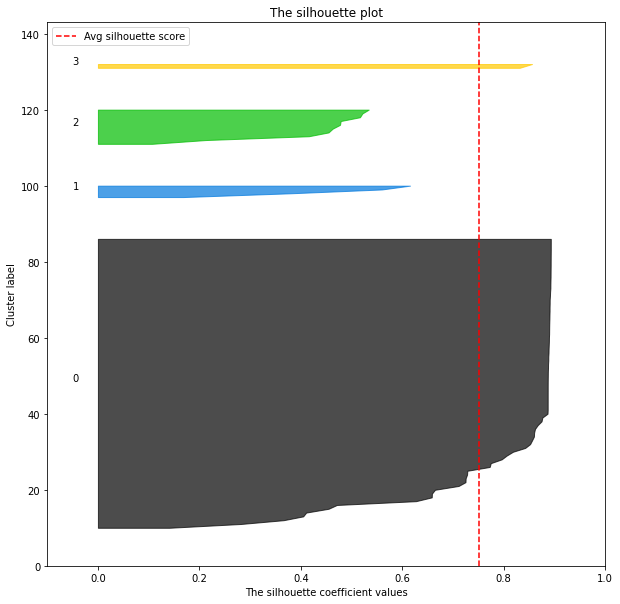

In [13]:
n_clusters = 4
plt.figure(figsize = (10,10))
plt.gca().set_xlim([-0.1,1])
plt.gca().set_ylim([0, len(X) + (n_clusters + 1) * 10])
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
labels = clusterer.fit_predict(X)
print("The average silhouette_score is :{}".format(silhouette_score(X, labels)))
sample_silhouette_values = silhouette_samples(X, labels)
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
    sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.gca().fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    plt.gca().text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.gca().axvline(x=silhouette_score(X, labels), color="red", linestyle="--", label = "Avg silhouette score")
plt.title("The silhouette plot")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")
plt.legend()
plt.show()

K = 5

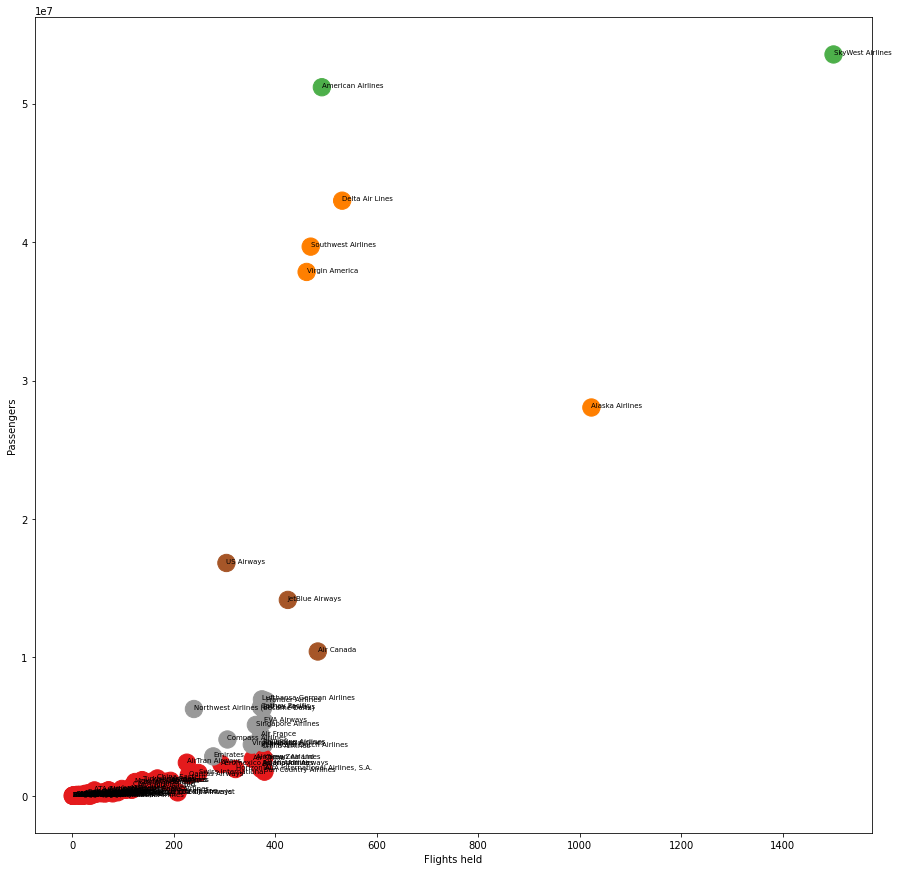

In [14]:
# Aplicação do algoritmo K-Means
kmeans = KMeans(n_clusters=5) # definindo a quantidade de clusters como 5
kmeans.fit(X) # realiza o treinamento
y_kmeans = kmeans.predict(X) # faz a predição

# Gráfico exibindo a clusterização realizada pelo K-Means
plt.figure(figsize = (15,15))
plt.xlabel("Flights held")
plt.ylabel("Passengers")
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=300, cmap='Set1')
for i, txt in enumerate(airline_count.index.values):
    plt.annotate(txt, (X[i,0], X[i,1]), size = 7)
plt.show()

The average silhouette_score is :0.7028484066427277


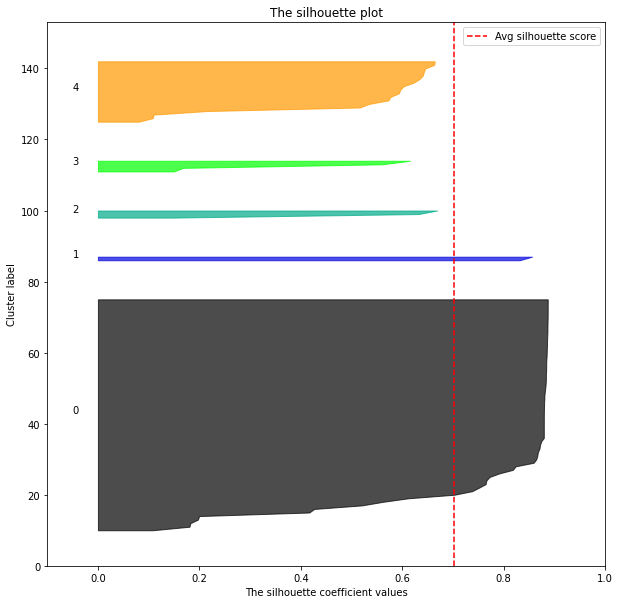

In [15]:
n_clusters = 5
plt.figure(figsize = (10,10))
plt.gca().set_xlim([-0.1,1])
plt.gca().set_ylim([0, len(X) + (n_clusters + 1) * 10])
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
labels = clusterer.fit_predict(X)
print("The average silhouette_score is :{}".format(silhouette_score(X, labels)))
sample_silhouette_values = silhouette_samples(X, labels)
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
    sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.gca().fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    plt.gca().text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.gca().axvline(x=silhouette_score(X, labels), color="red", linestyle="--", label = "Avg silhouette score")
plt.title("The silhouette plot")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")
plt.legend()
plt.show()

K = 6

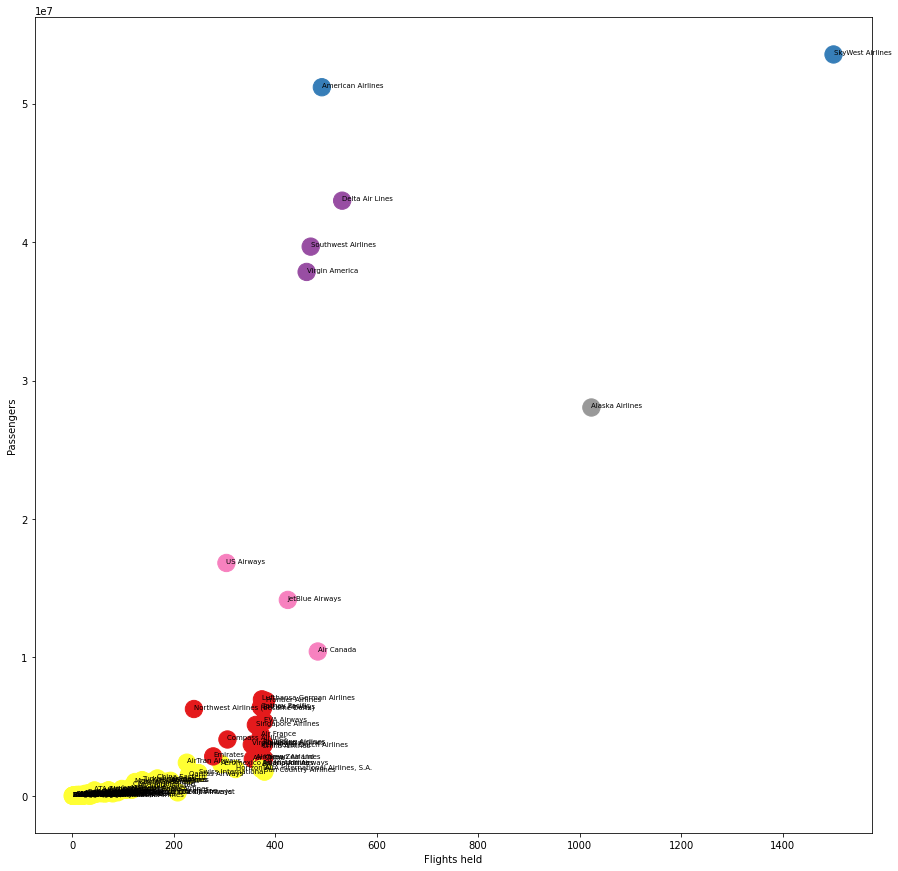

In [16]:
# Aplicação do algoritmo K-Means
kmeans = KMeans(n_clusters=6) # definindo a quantidade de clusters como 6
kmeans.fit(X) # realiza o treinamento
y_kmeans = kmeans.predict(X) # faz a predição

# Gráfico exibindo a clusterização realizada pelo K-Means
plt.figure(figsize = (15,15))
plt.xlabel("Flights held")
plt.ylabel("Passengers")
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=300, cmap='Set1')
for i, txt in enumerate(airline_count.index.values):
    plt.annotate(txt, (X[i,0], X[i,1]), size = 7)
plt.show()

Gráfico da Silhueta

The average silhouette_score is :0.706756905743921


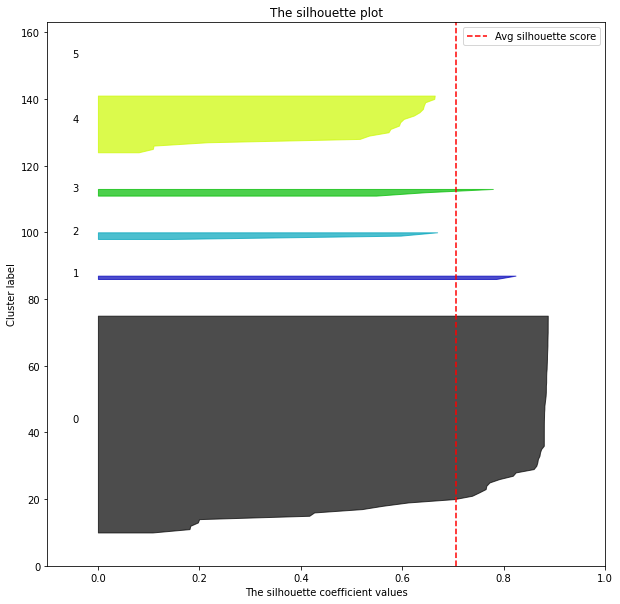

In [17]:
n_clusters = 6
plt.figure(figsize = (10,10))
plt.gca().set_xlim([-0.1,1])
plt.gca().set_ylim([0, len(X) + (n_clusters + 1) * 10])
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
labels = clusterer.fit_predict(X)
print("The average silhouette_score is :{}".format(silhouette_score(X, labels)))
sample_silhouette_values = silhouette_samples(X, labels)
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
    sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.gca().fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    plt.gca().text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.gca().axvline(x=silhouette_score(X, labels), color="red", linestyle="--", label = "Avg silhouette score")
plt.title("The silhouette plot")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")
plt.legend()
plt.show()

O gráfico da silhueta subsidia na avaliação do agrupamento encontrado. O coeficiente de silhueta (CS(i)) é uma medida de qualidade para toda estrutura de agrupamento que foi descoberta pelo algoritmo de classificação.


**Interpretação de agrupamentos segundo coeficiente de silhueta (CS(i)):**

0.71 − 1.00 Grupos descobertos possuem uma estrutura muito robusta

0.51 − 0.70 Grupos possuem uma estrutura razoável

0.26 − 0.50 Os grupos encontrados possuem uma estrutura fraca e pode ser artificial. 

≤ 0.25 Nenhuma estrutura foi descoberta


*Analisando o gráfico pode ser obsevado que 2 grupos estão entre o intervalo 0.51 − 0.70 e 3 grupos entre o intervalo 0.71 − 1.00*

#DBScan

Para meios de comparação, também foi utilizado o algoritmo DBScan 

#Encontrar melhores parâmetros

In [18]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

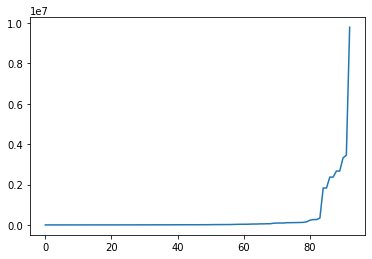

In [19]:
# A quantidade mínima de pontos foi definida como sendo 4 por estarmos trabalhando com dados bidimensionais. 
# (2 * dimensionalidade) = 4
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Foi utilizao o método KNN para calcular o melhor valor de ε para o conjunto de dados. 
# É calculado a distância média entre cada ponto e seus k vizinhos mais próximos, onde k = o valor MinPts selecionado. 
# As distâncias k médias são então plotadas em ordem crescente no gráfico de distâncias k. 

# plotando o gráfico de distâncias
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [20]:
# O valor ideal para ε é o ponto de curvatura máxima (ou seja, onde o gráfico tem a maior inclinação).

# Aplicação DBScan

In [21]:
from sklearn.cluster import DBSCAN

# aplicação do método 
dbscan = DBSCAN(eps = 0.2, min_samples=4)
dbscan.fit(X)
y_dbscan = dbscan.fit_predict(X)

labels = dbscan.labels_
print(labels)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [22]:
# Número de clusters em rótulos, ignorando o ruído, se houver.
print(len(set(labels)) - (1 if -1 in labels else 0))

0


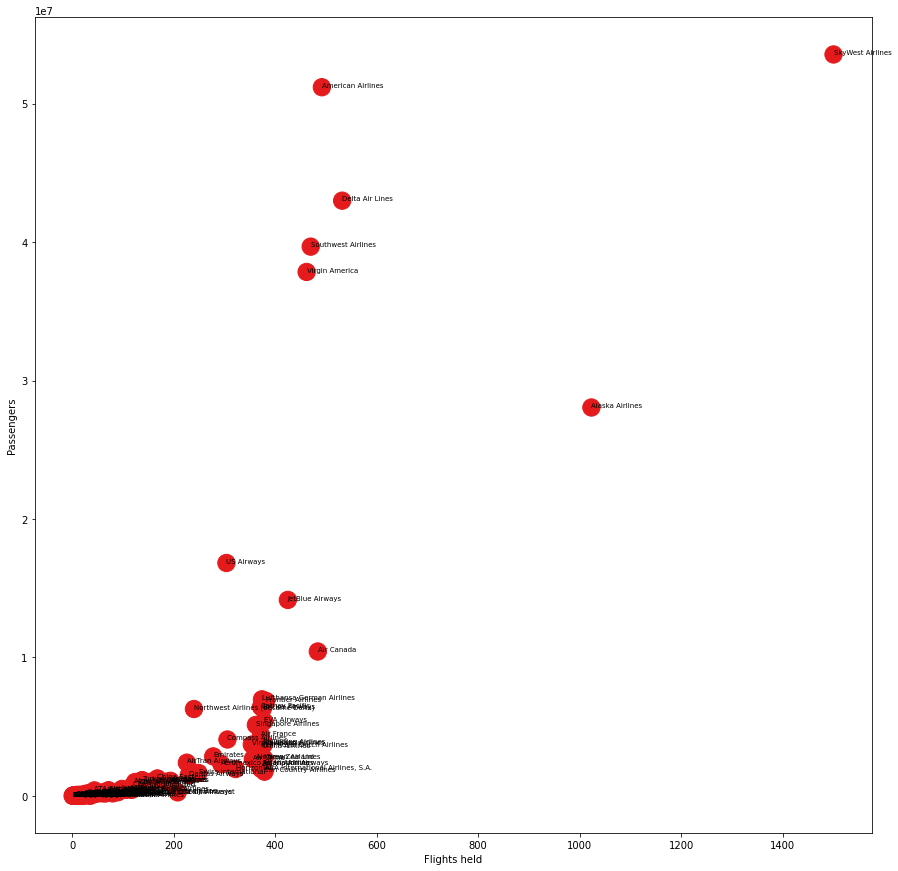

In [23]:
# Gráfico do DBScan
plt.figure(figsize = (15,15))
plt.xlabel("Flights held")
plt.ylabel("Passengers")
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan, s=300, cmap='Set1')
for i, txt in enumerate(airline_count.index.values):
    plt.annotate(txt, (X[i,0], X[i,1]), size = 7)
plt.show()

O resultado do DBScan não foi satisfatório, por conta da pequena proximidade entre os pontos da nossa amostragem. Com isso o algoritmo depois de executado considerou que todos os pontos periféricos pertenceriam a apenas um cluster, pois através da análise da densidade dos pontos o algoritmo concluiu que eles todos estavam bem próximos e teriam apenas um ponto central. Já os pontos considerados ruídos não são considerados pelo algoritmo DBScan e são descartados do resultado.